In [160]:
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

In [162]:
len(words)

32033

# Preprocess the data

In [163]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [164]:
import torch

# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> (torch.tensor, torch.tensor):
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 5
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


# Model

In [165]:
EMBED_SZ = 32
HIDDEN_LAYER_SZ = 96

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, EMBED_SZ), generator=g)

W1 = torch.randn((CONTEXT_SZ * EMBED_SZ, HIDDEN_LAYER_SZ), generator=g).abs() * 0.1
b1 = torch.randn(HIDDEN_LAYER_SZ, generator=g) * 0.01

W2 = torch.randn((HIDDEN_LAYER_SZ, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

# Reset parameters for training
for p in parameters:
    p.requires_grad = True
    
# Total number of parameters
sum(p.nelement() for p in parameters)

18939

# Training

In [175]:
relu = torch.nn.ReLU()

def forward_pass(x: torch.tensor) -> torch.tensor:
    """Forward pass."""
    emb = C[x] # (N, CONTEXT_SZ, 2)
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # Hidden layer pre-activation
    h = relu(hpreact)  # hidden layer  # (N, HIDDEN_LAYER_SZ)
    return h @ W2 + b2 # output layer (HIDDEN_LAYER_SZ, 27)

In [176]:
from statistics import mean
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F

MINI_BATCH_SZ = 128

# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.cat([-1 * torch.ones(100000), torch.linspace(-1, -5, steps=50000)])
lrs = 10**lre
#plt.plot(range(0, len(lrs)), lrs)

lri = []
lossi = []
loglossi = []
loglossiavg = []
stepi = []

pbar = tqdm(range(len(lrs)))
for i in pbar:
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,), generator=g) # (MINI_BATCH_SZ)
    Xb, Yb = Xtr[ix], Ytr[ix]

    with torch.no_grad():
        # This is repeated here for the exercise of looking at the impact of poor
        # initialization weights with respect to the activation function.
        h = relu(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1)

    logits = forward_pass(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Update parameters
    lr = lrs[i]
    sgd = torch.optim.SGD(parameters, lr=lr, weight_decay=0.001)
    sgd.zero_grad()
    loss.backward()
    sgd.step()

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    if i < 500:
        loglossiavg.append(loss.log10().item())
    else:
        loglossiavg.append(mean(loglossi[-500:]))
    if i % 1000 == 0:
        pbar.set_description("LR: %0.4f Loss %0.4f" % (lr, mean(lossi[-500:])))

LR: 0.0000 Loss 2.0627: 100%|██████████| 150000/150000 [01:15<00:00, 1978.18it/s]


Initialization


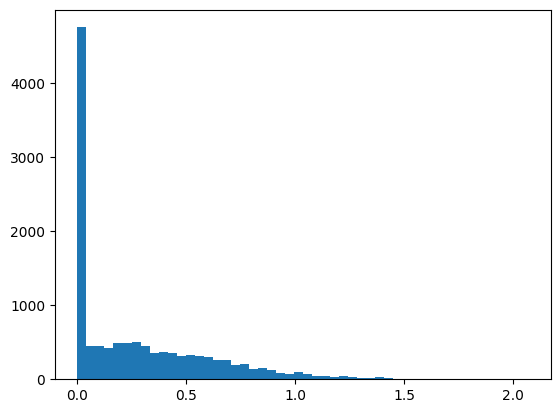

In [177]:
plt.hist(h.view(-1).tolist(), 50)
print("Initialization")

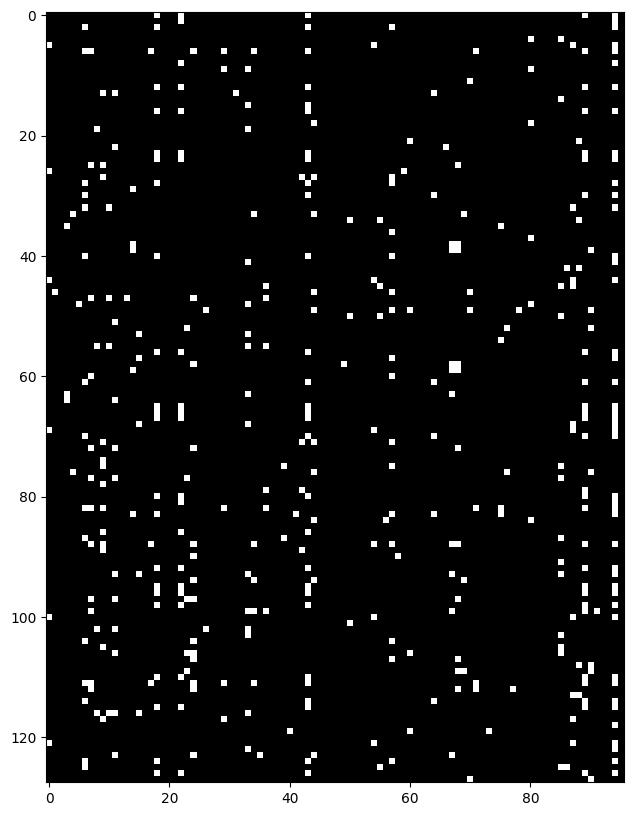

In [178]:
# Visualizing dead neurons
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Evaluate Loss

0.444754034280777

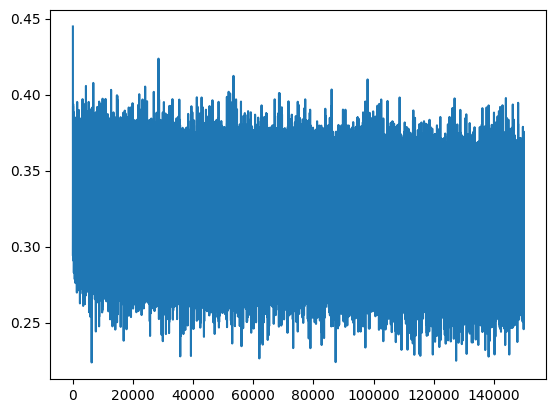

In [179]:
plt.plot(stepi, loglossi)
loglossi[0]

In [180]:
# Expected loss at initialization
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [181]:
print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
    'num_parameters': sum(p.nelement() for p in parameters),
})

with torch.no_grad():
    xtr_loss = F.cross_entropy(forward_pass(Xtr), Ytr)
    print(f"Xtr loss: {xtr_loss:0.4f}")

    xdev_loss = F.cross_entropy(forward_pass(Xdev), Ydev)
    print(f"Xdev loss: {xdev_loss:0.4f}")

{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0637
Xdev loss: 2.0897


# Sample from the Model

In [173]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        x = torch.tensor([context])
        logits = forward_pass(x)

        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)

        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

carmah.
amille.
khirmis.
reety.
salaya.
ejrahnen.
deliyat.
kaqui.
nellara.
chaiiv.
kaleig.
dham.
joce.
quinn.
shoil.
alian.
quwanthon.
jaryni.
jaceeni.
sabee.


# Improvement Log

## Initialization Improvements

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0590
Xdev loss: 2.0950
```

## Saturated Tanh

I previously discovered independently that `ReLU` performed better than `tanh`. This appears to be because of the gradient squashing ocurring? However, this also happens with `ReLU` has negative weights -- so the same issue but in a different region of the space.


# Unsaturated Tanh

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0943
Xdev loss: 2.1121
```

# ReLU

Moving back to ReLU with adjusted weights.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 5, 'EMBED_SZ': 32, 'HIDDEN_LAYER_SZ': 96, 'num_parameters': 18939}
Xtr loss: 2.0637
Xdev loss: 2.0897
```